# Pt2FE
- This is a demo for applying the Pt2FE method
- The demo are arranged in the following steps:
    - 1) Data Preparing
    - 2) Data Processing
    - 3) 3D Reconstruction
    - 4) Convert into ANSYS APDL workflow (FE Model)
- Although I called this demo as automatic, but somehow I have to admit that this demo was actually semi-auto to use. Since some parameters you need to decide by yourself.

## Now, let's get started

## PART 1 : DATA PREPARING

- So, just put your orginal pointcloud data into the data/org_data file.
- Make sure that your file could be opened in the PointCloud software like CloudCompare or Geomagic Wrap...... in another word, make sure your file is .pcd(binary).
    - During the further steps, we may need several kinds of data format (.pcd(binary),.pcd(ascii),.csv and so on), so we prepared the format transformation function in the same-name file.
- The unit of your Pts data should consistent with the reality.

#### let us use the open3d lib to have quick glance of your data.

In [1]:
#import open3d as o3d
from data_preparing.visualize_pt import visualize_pcd

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
visualize_pcd('data/org_data/data_org.pcd')

- Compare the PointCloud data with your original one, make sure that they are formally same with each other

- Then, we can transfer your orginal .pcd file into different format

In [9]:
# transfer your original file
from format_transformation.ascii_to_binary import ascii_to_binary
from format_transformation.pcd2txt import pcd_to_txt
from format_transformation.txt_2_csv import txt_to_csv

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
ascii_to_binary("./data/org_data/data_org.pcd","./data/org_data/data_org_b.pcd")

In [5]:
pcd_to_txt("./data/org_data/data_org.pcd", "./data/org_data/data_org_txt.txt")

In [10]:
txt_to_csv("./data/org_data/data_org_txt.txt", "./data/org_data/data_org_csv.csv")

## PART 2 : DATA PROCESSING

- Now, we are going to the data processing step.

### 2.1 : Coordinate Adjustment

- If your data are offset with the reality, you may could apply this part
- In this section, we may also use plane fitting method, which we would discuss later in section 2.2

In [2]:
#2.1.1 clustering the data in order to find the different planes in your data
import numpy as np

from data_processing.algorithm_clustering.points_to_surface3 import initialize_planes_with_kmeans, refine_planes

In [3]:
points_sample = np.loadtxt('./data/org_data/data_org_txt.txt')
n_planes = 3

In [4]:
initial_planes = initialize_planes_with_kmeans(points_sample, n_planes)
refined_planes, refined_assignments = refine_planes(points_sample, initial_planes)

In [7]:
#visualization
from data_processing.algorithm_clustering.points_to_surface3 import plot_points_by_group

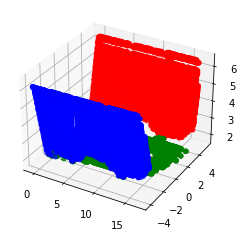

In [8]:
plot_points_by_group(points_sample, refined_assignments)

- To see whether if the result does make sense to the reality. (Each color represent to a plane) 
- The Relationship between color and plane:
    - ['r', 'g', 'b','orange','purple','black']

In [11]:
#将结果存入.csv文件
import pandas as pd
ass_series = pd.Series(refined_assignments)
csv_file = './data/org_data/data_org_csv.csv'
df = pd.read_csv(csv_file)
df['cluster'] = ass_series
df.to_csv("./data/org_data/data_org_clu.csv", index=False)

In [ ]:
#2.1.2 定义底边方向


### 2.2 : Plane Fitting (Clustering)

### 2.3 : Extarct Key Point 

### 2.4 : Supplementary operation